# Importing Libraries

In [1]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import log_loss
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Some Functions

In [2]:
# Function to extract HOG features from an image
def extract_hog_features(image):
    _, hog_features = hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
    return hog_features.flatten()



# Load images from a directory for selected fruits
def load_selected_images(base_directory, selected_fruits):
    images = []
    labels = []
    fruit_counts = {}  # Dictionary to store the count for each fruit
    fruit_labels=0
    for fruit_name in selected_fruits:
        fruit_directory = os.path.join(base_directory, fruit_name)
        if os.path.isdir(fruit_directory):
            fruit_count = 0  # Initialize count for the current fruit
            for filename in os.listdir(fruit_directory):
                if filename.endswith(".jpg"):

                    image_path = os.path.join(fruit_directory, filename)
                    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (64, 64))  # Resize images to a consistent size
                    images.append(img)
                    labels.append(fruit_labels)
                    fruit_count += 1
            fruit_labels+=1                    
            fruit_counts[fruit_name] = fruit_count  # Store the count for the current fruit
            
    return np.array(images), np.array(labels), fruit_counts

# Load Dataset (load selected fruits)

In [3]:
# Base directory containing fruit images
base_directory = "C:\\Users\\ysfah\\OneDrive\\Desktop\\ml\\Image Dataset\\fruits-360"

# User-provided list of selected fruits
selected_fruits = ["Apple Braeburn", "Banana", "Strawberry","Pineapple","Mango"]

# Load and preprocess the training dataset for selected fruits
train_images, train_labels, train_fruit_counts = load_selected_images(os.path.join(base_directory, "Training"), selected_fruits)

# Load and preprocess the testing dataset for selected fruits
test_images, test_labels, test_fruit_counts = load_selected_images(os.path.join(base_directory, "Test"), selected_fruits)




In [4]:
# Print the count for each fruit after importing
print("Training Set Fruit Counts:")
for fruit, count in train_fruit_counts.items():
    print(f"{fruit}: {count} images")

print("\nTesting Set Fruit Counts:")
for fruit, count in test_fruit_counts.items():
    print(f"{fruit}: {count} images")

Training Set Fruit Counts:
Apple Braeburn: 492 images
Banana: 490 images
Strawberry: 492 images
Pineapple: 490 images
Mango: 490 images

Testing Set Fruit Counts:
Apple Braeburn: 164 images
Banana: 166 images
Strawberry: 164 images
Pineapple: 166 images
Mango: 166 images


# Feature Extraction

In [5]:
# Extract HOG features from each image
hog_features_train = [extract_hog_features(image) for image in train_images]
hog_features_test = [extract_hog_features(image) for image in test_images]

# Merging both sets

In [6]:
hog_features_all = np.concatenate((hog_features_train, hog_features_test), axis=0)
all_labels = np.concatenate((train_labels, test_labels), axis=0)

# Logistic Regression

## Training Model

In [7]:

# Create and train Logistic Regression model
logistic_regression = LogisticRegression(multi_class='ovr', max_iter=1000)
history = logistic_regression.fit(hog_features_train, train_labels)



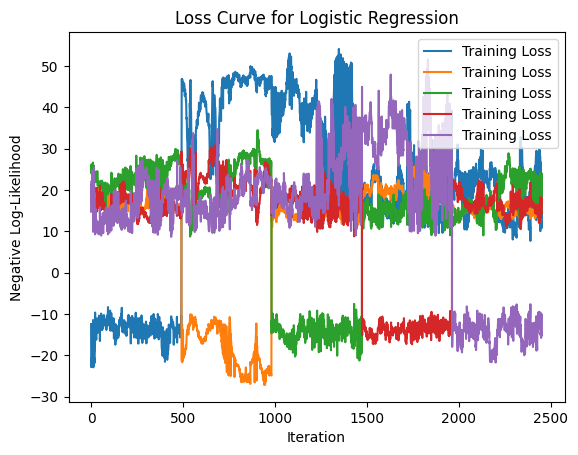

In [8]:
# Plot the loss curve
loss_values = -np.array(history.decision_function(hog_features_train))
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Negative Log-Likelihood')
plt.title('Loss Curve for Logistic Regression')
plt.legend()
plt.show()

## Testing

In [9]:
# Predict on the testing set
y_pred = logistic_regression.predict(hog_features_test)

## Confusion Matrix

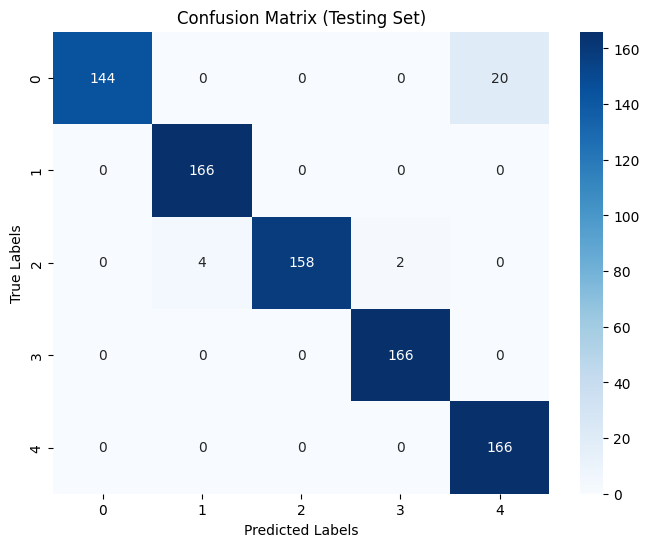

In [10]:
# Display the confusion matrix for the testing set
conf_matrix_test = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(train_labels), yticklabels=np.unique(train_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Testing Set)')
plt.show()

## Calculate Accuracy

In [11]:
# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy on the testing set: {accuracy * 100:.2f}%")

Accuracy on the testing set: 96.85%


## Random Samples

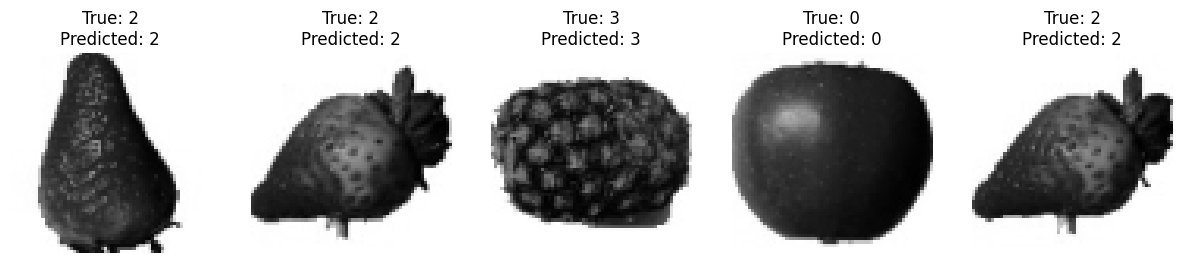

In [12]:
# Display some randomly selected images along with their true labels and predicted labels
sample_indices = np.random.choice(len(test_images), size=5, replace=False)

plt.figure(figsize=(15, 5))
for i, index in enumerate(sample_indices, 1):
    plt.subplot(1, 5, i)
    plt.imshow(test_images[index], cmap='gray')
    true_label = test_labels[index]
    pred_label = y_pred[index]
    plt.title(f"True: {true_label}\nPredicted: {pred_label}")
    plt.axis('off')

plt.show()

## Plot ROC curve

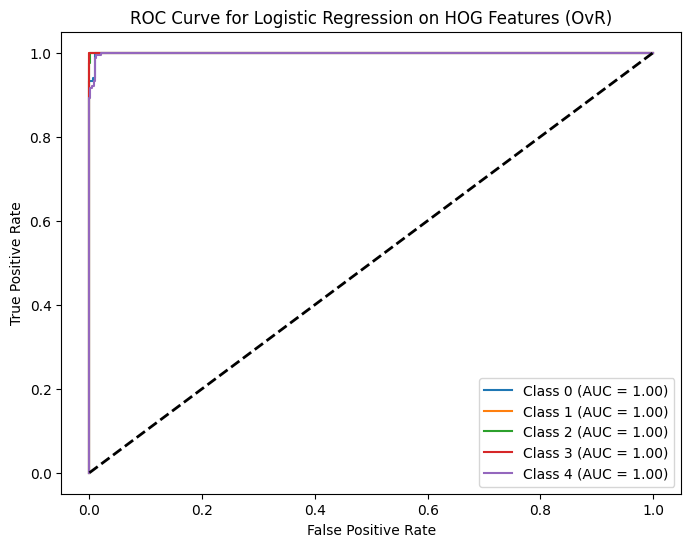

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Assuming you have hog_features_test_standardized for the test set and test_labels
# Also, assuming logistic_regression is already trained

# Binarize the labels for the ROC curve
test_labels_bin = label_binarize(test_labels, classes=np.unique(train_labels))

# Predict probabilities for each class
y_score = logistic_regression.decision_function(hog_features_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(selected_fruits)):  # Assuming 5 classes in this example
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))

for i in range(len(selected_fruits)):
    plt.plot(fpr[i], tpr[i], label=f'Class {np.unique(test_labels)[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression on HOG Features (OvR)')
plt.legend(loc='lower right')
plt.show()

# K-Mean

In [14]:
# Apply K-Means clustering on the standardized training set
#pca = PCA(n_components=2)
#hog_features_train_standardized = pca.fit_transform(hog_features_train_standardized)
#hog_features_test_standardized = pca.fit_transform(hog_features_test_standardized)
k = len(np.unique(all_labels))  # Chzoose the number of clusters based on the number of classes
kmeans = KMeans(n_clusters=k, random_state=42,n_init=10)
y=kmeans.fit(hog_features_all)


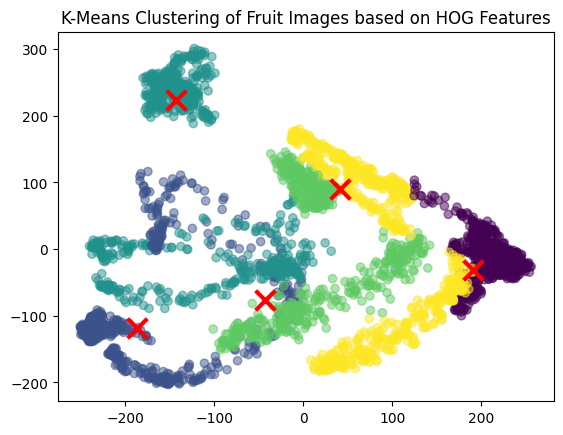

In [15]:
# Visualize results (optional)
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(hog_features_all)
reduced_centroids = pca.transform(kmeans.cluster_centers_)

plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=all_labels, cmap='viridis', alpha=0.5)
plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], marker='x', s=200, linewidths=3, color='r')
plt.title('K-Means Clustering of Fruit Images based on HOG Features')
plt.show()

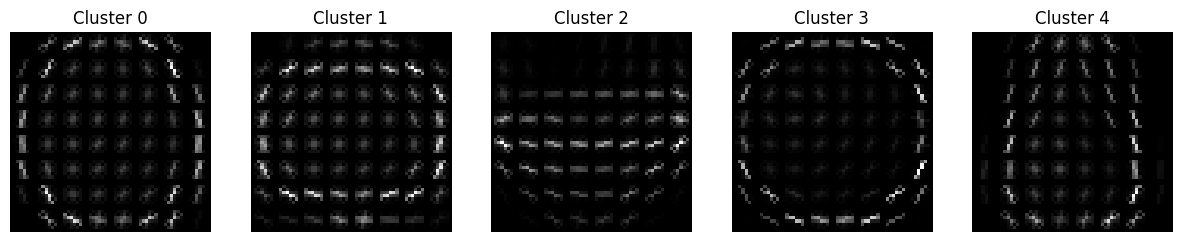

In [16]:
# Visualize the cluster centers (representative images)
fig, ax = plt.subplots(1, len(np.unique(all_labels)), figsize=(15, 3))

for i in range(len(np.unique(all_labels))):
    center_image = kmeans.cluster_centers_[i].reshape(64, 64)  # Reshape to original dimensions
    ax[i].imshow(center_image, cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'Cluster {i}')

plt.show()
